# MOM6 ANALYSIS - Overview Plot
The key purpose of this notebook will be to create an overview plot of the Study region.
I'd like this overview plot to be a simple, clear picture of the nesting approach, as well as baseline picture of the EAC dynamics and flow fields. 

Let's keep this very simple. I want to show a large-scale overview-plot that has ACCESS, SOUTHPAC-01, and EAC-003. I think for this, the simpler the better. Even just showing meridional velocities.

In [1]:
import matplotlib.pyplot as plt
import cmocean as cm
import xarray as xr
import numpy as np
import glob
import xesmf

In [2]:
from xgcm import Grid

from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [3]:
# import cartopy to plot maps
import cartopy.crs as ccrs
import cartopy.feature as feature
land_50m = feature.NaturalEarthFeature('physical', 'land', '50m', 
                                       edgecolor='black',
                                       facecolor='gray',
                                       linewidth=0.2)

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39749,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:33249,Total threads: 4
Dashboard: /proxy/44153/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:45829,


## Contents
### 1. Set paths, choose variables, open datasets
### 2. Preprocessing - subsetting, re-gridding etc.

## Section 1 - Setup

In [5]:
# set paths to model output
## SRM
eac_003 = '/scratch/v45/jr5971/mom6/archive/eac-003-latest/'
## LRM
sthpac_01 = '/scratch/v45/jr5971/mom6/archive/southpac-01/'
## PARENT
access = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/'

Right, so we've got our paths to the model output. Now we want to start by getting velocities from each of the models.

In [6]:
import os
os.chdir('/home/581/jr5971/jr5971/notebooks/')
from custom_funcs import *

#### Load OM2 data

In [7]:
# get vars from access;
om2_iaf, _ = open_iaf_global(input_vars=['u','v','temp'],
                            decode_times=True)
om2_iaf

<xarray.Dataset>
Dimensions:         (xt_ocean: 3600, yt_ocean: 2700, st_ocean: 75,
                     st_edges_ocean: 76, time: 2191, nv: 2, xu_ocean: 3600,
                     yu_ocean: 2700)
Coordinates:
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * time            (time) datetime64[ns] 1990-01-01T12:00:00 ... 1995-12-31T...
  * nv              (nv) float64 1.0 2.0
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
Data variables:
    temp            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(31, 75, 300, 300), meta=np.ndarray>
    average_T1      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_T2      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_DT      (time) timedelta64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    time_bnds       (time, nv) timedelta64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    u               (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(31, 75, 300, 300), meta=np.ndarray>
    v               (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(31, 75, 300, 300), meta=np.ndarray>
Attributes:
    filename:   ocean-3d-temp-1-daily-mean-ym_1990_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20221019T1326Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

**Note - this is the typical way of doing things, but for now we're just loading in the single velocity files from the new eac-003 run**

#### Load EAC data

In [7]:
eac_u_files = get_mom6_files(path=eac_003, years = 'all', input_vars=['u'])
eac_v_files = get_mom6_files(path=eac_003, years = 'all', input_vars=['v'])
eac_temp_files = get_mom6_files(path=eac_003, years='all', input_vars=['tos'])
eac_u_files.sort()
# eac_u = xr.open_mfdataset(eac_u_files[:14])

In [ ]:
eac_v_files.sort()
eac_v = xr.open_mfdataset(eac_v_files[:14])

In [10]:
eac_u = xr.open_dataset(eac_003 + 'output033/19921201.ocean_daily_u_3d.nc')
eac_v = xr.open_dataset(eac_003 + 'output033/19921201.ocean_daily_v_3d.nc')
eac_u

<xarray.Dataset>
Dimensions:     (xh: 594, yh: 1140, z_l: 100, z_i: 101, time: 31, nv: 2, xq: 595)
Coordinates:
  * xh          (xh) float64 -217.8 -217.7 -217.7 ... -198.1 -198.0 -198.0
  * yh          (yh) float64 -46.18 -46.16 -46.13 ... -14.14 -14.11 -14.07
  * z_l         (z_l) float64 0.2928 0.8999 1.552 ... 5.134e+03 5.324e+03
  * z_i         (z_i) float64 0.0 0.5856 1.214 ... 5.04e+03 5.229e+03 5.419e+03
  * time        (time) object 1992-12-01 12:00:00 ... 1992-12-31 12:00:00
  * nv          (nv) float64 1.0 2.0
  * xq          (xq) float64 -217.8 -217.8 -217.7 ... -198.1 -198.0 -198.0
Data variables:
    volcello    (time, z_l, yh, xh) float32 ...
    uo          (time, z_l, yh, xq) float32 ...
    average_T1  (time) datetime64[ns] ...
    average_T2  (time) datetime64[ns] ...
    average_DT  (time) timedelta64[ns] ...
    time_bnds   (time, nv) object ...
Attributes:
    NumFilesInSet:  1
    title:          eac
    grid_type:      regular
    grid_tile:      N/A

In [11]:
eac_u_da = eac_u['uo']
eac_v_da = eac_v['vo']
eac = xr.merge([eac_u_da, eac_v_da])
eac

<xarray.Dataset>
Dimensions:  (yh: 1140, z_l: 100, time: 31, xq: 595, xh: 594, yq: 1141)
Coordinates:
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -14.14 -14.11 -14.07
  * z_l      (z_l) float64 0.2928 0.8999 1.552 ... 4.946e+03 5.134e+03 5.324e+03
  * time     (time) object 1992-12-01 12:00:00 ... 1992-12-31 12:00:00
  * xq       (xq) float64 -217.8 -217.8 -217.7 -217.7 ... -198.1 -198.0 -198.0
  * xh       (xh) float64 -217.8 -217.7 -217.7 -217.7 ... -198.1 -198.0 -198.0
  * yq       (yq) float64 -46.19 -46.17 -46.14 -46.12 ... -14.12 -14.09 -14.06
Data variables:
    uo       (time, z_l, yh, xq) float32 ...
    vo       (time, z_l, yq, xh) float32 ...
Attributes:
    units:          m s-1
    long_name:      Sea Water X Velocity
    cell_methods:   z_l:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

#### Load STHPAC data

In [12]:
sthpac_u_files = get_mom6_files(path=sthpac_01, years=[1992,1993],
                                input_vars=['u'])
sthpac_u = xr.open_mfdataset(sthpac_u_files)

In [13]:
sthpac_v_files = get_mom6_files(path=sthpac_01, years=[1992,1993],
                                input_vars=['v'])
sthpac_v = xr.open_mfdataset(sthpac_v_files)

In [14]:
sthpac_u_da = sthpac_u['uo']
sthpac_v_da = sthpac_v['vo']
sthpac = xr.merge([sthpac_u_da, sthpac_v_da])

### Choose spatial and temporal extent
In order to make the regridding quicker later on, let's choose a temporal extent now. 

**Because we are just using the single month from eac-003, we need to select dates from the other models from within that time period**

In [15]:
daterange = [eac.time.min().values.astype(str).item(), eac.time.max().values.astype(str).item()]
daterange

['1992-12-01 12:00:00', '1992-12-31 12:00:00']

In [16]:
# subset datasets in time
om2_iaf = om2_iaf.sel(time=slice(daterange[0], daterange[1]))
sthpac = sthpac.sel(time=slice(daterange[0], daterange[1]))
# don't need to subset eac...

### Make Grids Symmetric

In [17]:
# EAC
# bottom corner "centre" coord
print('Bottom left centre points: ', np.round(eac.xh.min().values, 2), np.round(eac.yh.min().values,2))
# bottom left "corner" coord...
print('Bottom left CORNER points: ', np.round(eac.xq.min().values, 2), np.round(eac.yq.min().values,2))

Bottom left centre points:  -217.78 -46.18
Bottom left CORNER points:  -217.8 -46.19


In [18]:
# CREATE SYMMETRIC DATASETS
eac_symmetric = eac.isel(xq=slice(1,len(eac.xq)), yq = slice(1,len(eac.yq)))
sthpac_symmetric = sthpac.isel(xq=slice(1,len(sthpac.xq)), yq=slice(1,len(sthpac.yq)))

In [19]:
# EAC
# bottom corner "centre" coord
print('Bottom left centre points: ', np.round(eac_symmetric.xh.min().values, 2), np.round(eac_symmetric.yh.min().values,2))
# bottom left "corner" coord...
print('Bottom left CORNER points: ', np.round(eac_symmetric.xq.min().values, 2), np.round(eac_symmetric.yq.min().values,2))

Bottom left centre points:  -217.78 -46.18
Bottom left CORNER points:  -217.77 -46.17


In [21]:
# get grid cell thickness data
eac_static = xr.open_dataset('/home/581/jr5971/scratch/mom6/archive/eac-003-latest/output000/19900202.ocean_static.nc')
sthpac_static = xr.open_dataset('/home/581/jr5971/scratch/mom6/archive/southpac-01/output000/19900101.ocean_static.nc')

eac_symmetric['dxt'] = eac_static['dxt']
eac_symmetric['dyt'] = eac_static['dyt']
sthpac_symmetric['dxt'] = sthpac_static['dxt']
sthpac_symmetric['dyt'] = sthpac_static['dyt']


# Define new aligned grids
metrics = { 
    ('X',) : ['dxt'], # X distances
    ('Y',) : ['dyt'] # Y  distances
}
coords = {'X' : {'center':'xh', 'right':'xq'},
          'Y' : {'center':'yh', 'right':'yq'} }

eac_grid = Grid(eac_symmetric, coords=coords, metrics=metrics, periodic=False)
sthpac_grid = Grid(sthpac_symmetric, coords=coords, metrics=metrics, periodic=False)
eac_grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   xh --> right
  * right    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> right
  * right    yq --> center

Overwrite the meridional velocities (`vo`) in the symmetric datasets with the new offset points

In [ ]:
%%time
eac_symmetric['vo'] = eac_grid.interp(eac_symmetric['vo'], axis=['X','Y'])
sthpac_symmetric['vo'] = sthpac_grid.interp(sthpac_symmetric['vo'], axis=['X','Y'])
print(eac_symmetric['vo'].dims, eac['vo'].dims)

**NOTE: Be mindful to use the `symmetric` datasets going forward, not the original ones**
### Subset ACCESS data

In [23]:
# subset global to some region just bigger than the sthpac model...
sthpac_idx = {'W':sthpac.xh.min().values, 'E':sthpac.xh.max().values, 
              'S':sthpac.yh.min().values, 'N':sthpac.yh.max().values}
eac_idx = {'W':eac.xh.min().values, 'E':eac.xh.max().values,
           'S':eac.yh.min().values, 'N':eac.yh.max().values}
om2_subset = om2_iaf.sel(xu_ocean=slice(sthpac_idx['W'] - 30, sthpac_idx['E']+50),
                                          yu_ocean = slice(sthpac_idx['S']-30, sthpac_idx['N']+30))

Now, let's again think simply. Overview plot. First can we just plot om2 speed?
### What z-level are we taking - I'd really like to capture the eac dynamics so let's try top 50m

The following loop goes through each model that we have saved in `ds_dict` and gets the depth integrated velocities over the first 100 m. The result is then saved in each model output of the same dictionary. 

In [24]:
depth = 5 # metres
# select depth range from symmetric datasets and om2_subset
om2_2d = om2_subset.sel(st_ocean=depth, method='nearest')
eac_sym_2d = eac_symmetric.sel(z_l=depth, method='nearest')
sthpac_sym_2d = sthpac_symmetric.sel(z_l=depth, method='nearest')
sthpac_sym_2d

<xarray.Dataset>
Dimensions:  (yh: 705, time: 31, xq: 425, xh: 425, yq: 705)
Coordinates:
  * yh       (yh) float64 -49.96 -49.9 -49.83 -49.77 ... 12.16 12.26 12.35 12.45
    z_l      float64 4.332
  * time     (time) object 1992-12-01 12:00:00 ... 1992-12-31 12:00:00
  * xq       (xq) float64 -219.9 -219.8 -219.7 -219.6 ... -177.7 -177.6 -177.5
  * xh       (xh) float64 -219.9 -219.8 -219.7 -219.6 ... -177.7 -177.6 -177.5
  * yq       (yq) float64 -49.93 -49.87 -49.8 -49.74 ... 12.21 12.3 12.4 12.5
Data variables:
    uo       (time, yh, xq) float32 dask.array<chunksize=(31, 705, 425), meta=np.ndarray>
    vo       (time, yq, xh) float32 dask.array<chunksize=(31, 705, 425), meta=np.ndarray>
    dxt      (yh, xh) float32 ...
    dyt      (yh, xh) float32 ...
Attributes:
    units:          m s-1
    long_name:      Sea Water X Velocity
    cell_methods:   z_l:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

## Plotting
### 1. Plot snapshots of Speed 

In [25]:
from matplotlib import patches
import cartopy.feature as cfeature
import matplotlib.lines as mlines
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [31]:
eac_sym_2d

<xarray.Dataset>
Dimensions:  (yh: 1140, time: 31, xq: 594, xh: 594, yq: 1140)
Coordinates:
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -14.14 -14.11 -14.07
    z_l      float64 4.673
  * time     (time) object 1992-12-01 12:00:00 ... 1992-12-31 12:00:00
  * xq       (xq) float64 -217.8 -217.7 -217.7 -217.7 ... -198.1 -198.0 -198.0
  * xh       (xh) float64 -217.8 -217.7 -217.7 -217.7 ... -198.1 -198.0 -198.0
  * yq       (yq) float64 -46.17 -46.14 -46.12 -46.1 ... -14.12 -14.09 -14.06
Data variables:
    uo       (time, yh, xq) float32 ...
    vo       (time, yq, xh) float32 ...
    dxt      (yh, xh) float32 ...
    dyt      (yh, xh) float32 ...
Attributes:
    units:          m s-1
    long_name:      Sea Water X Velocity
    cell_methods:   z_l:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

In [34]:
sthpac_2d_snap = sthpac_2d_snap.load()


In [ ]:
sthpac_speed = np.sqrt(sthpac_2d_snap['vo']**2 + sthpac_2d_snap['uo']**2).compute()


In [ ]:
%%time
# Choose single day to calculate speed for all variables. 
day = '1992-12-07'
om2_2d_snap = om2_2d.sel(time=day)
sthpac_2d_snap = sthpac_sym_2d.sel(time=day)
eac_2d_snap = eac_sym_2d.sel(time=day)

# Calculate snapshot of speed
om2_speed = np.sqrt(om2_2d_snap['v']**2 + om2_2d_snap['u']**2).compute()
print('om2 finished')
sthpac_speed = np.sqrt(sthpac_2d_snap['vo']**2 + sthpac_2d_snap['uo']**2).compute()
print('sthpac finished')
eac_speed = np.sqrt(eac_2d_snap['vo']**2 + eac_2d_snap['uo']**2).compute()

In [28]:
import matplotlib.ticker as mticker
import cartopy.crs as ccrs


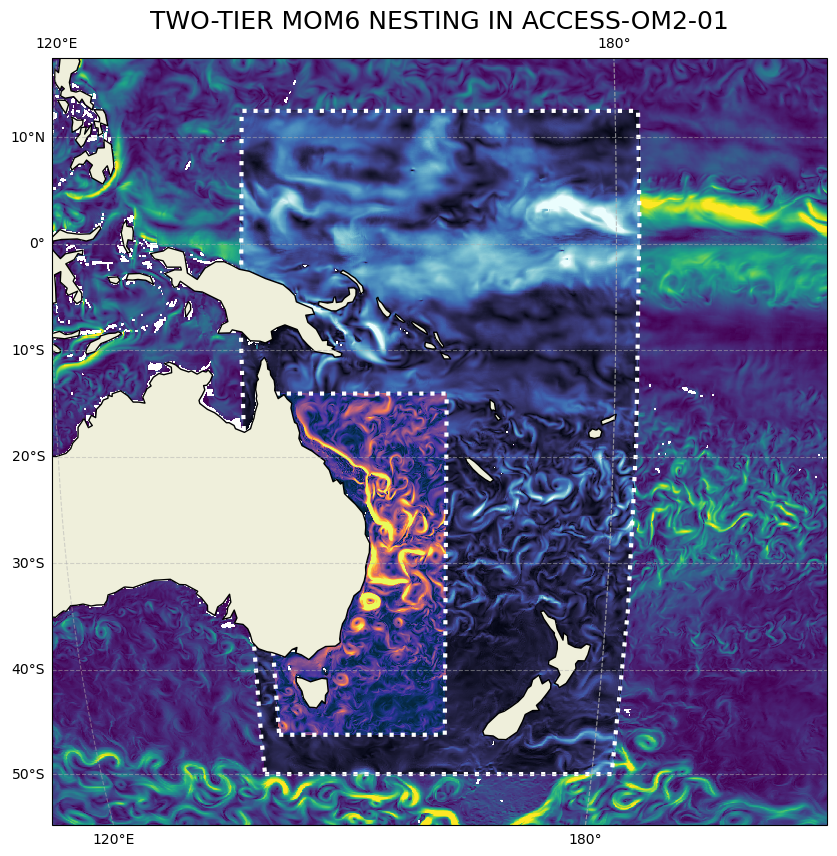

In [57]:
# create figure
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-200))

# Plot access 
om2_speed.plot(ax=ax, vmin=0, vmax=.7, transform=ccrs.PlateCarree(), zorder=0, alpha=1, add_colorbar=False)
sthpac_speed.plot(ax=ax,vmin=0, vmax=.7, transform=ccrs.PlateCarree(), cmap=cm.cm.ice, add_colorbar=False)
eac_speed.plot(ax=ax,vmin=0, vmax=.7, transform=ccrs.PlateCarree(), cmap=cm.cm.thermal, add_colorbar=False)

box1 = patches.Rectangle((sthpac_idx['W'], sthpac_idx['S']), (sthpac_idx['E']-sthpac_idx['W']), 
                        (sthpac_idx['N']-sthpac_idx['S']), color='w', fill=None, transform=ccrs.PlateCarree(),
                        alpha=1, linestyle=':', linewidth=3)
box2 = patches.Rectangle((eac_idx['W'], eac_idx['S']), (eac_idx['E']-eac_idx['W']), 
                        (eac_idx['N']-eac_idx['S']), color='w', fill=None, transform=ccrs.PlateCarree(),
                        alpha=1, linestyle=':', linewidth=3)

ax.add_patch(box1); ax.add_patch(box2)

ax.add_feature(cfeature.LAND, zorder=0)

ax.add_feature(cfeature.LAND, zorder=1)
# ax.gridlines()

extent = [sthpac_idx['W']-20, sthpac_idx['E']+20, sthpac_idx['S']-5, sthpac_idx['N']+5]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.coastlines()

ax.set_title('TWO-TIER MOM6 NESTING IN ACCESS-OM2-01', fontsize=18)

# Set custom ticks on x and y axes
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree());

# # Add latitude and longitude labels to the ticks
# lon_formatter = LongitudeFormatter(zero_direction_label=True)
# lat_formatter = LatitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)

ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')

fig.savefig('/home/581/jr5971/jr5971/notebooks/figures/nesting_overview_3cmap_wt-gridlines.png')

## Plot 2 - High-res snapshot

In [62]:
eac_2d_snap

<xarray.Dataset>
Dimensions:  (yh: 1140, time: 1, xq: 594, xh: 594, yq: 1140)
Coordinates:
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -14.14 -14.11 -14.07
    z_l      float64 4.673
  * time     (time) object 1992-10-10 12:00:00
  * xq       (xq) float64 -217.8 -217.7 -217.7 -217.7 ... -198.1 -198.0 -198.0
  * xh       (xh) float64 -217.8 -217.7 -217.7 -217.7 ... -198.1 -198.0 -198.0
  * yq       (yq) float64 -46.17 -46.14 -46.12 -46.1 ... -14.12 -14.09 -14.06
Data variables:
    uo       (time, yh, xq) float32 -0.02677 -0.005465 ... -0.2489 -0.2552
    vo       (time, yh, xq) float32 nan nan nan nan ... -0.05078 -0.04243 nan
    dxt      (yh, xh) float32 ...
    dyt      (yh, xh) float32 ...
Attributes:
    units:          m s-1
    long_name:      Sea Water X Velocity
    cell_methods:   z_l:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

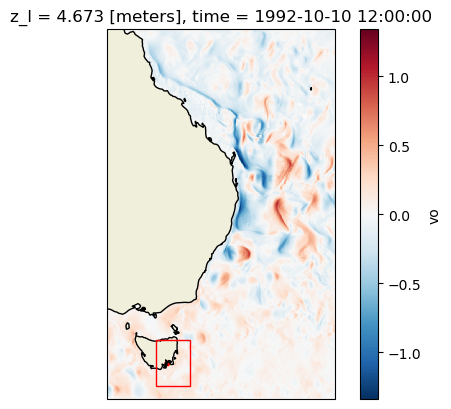

In [63]:
smokey_cape = [147.44-360, -43.1]

ax = plt.axes(projection=ccrs.PlateCarree())
eac_2d_snap['vo'].plot(ax=ax)
ax.scatter(smokey_cape[0], smokey_cape[1], color='red', marker='o', s=10)

b = 2 # set buffer
smokey_box = {'W':smokey_cape[0]-(b/2), 'E':smokey_cape[0]+b, 'S':smokey_cape[1]-b, 'N':smokey_cape[1]+b}
box_sc = patches.Rectangle((smokey_box['W'], smokey_box['S']), (smokey_box['E']-smokey_box['W']),
                           (smokey_box['N']-smokey_box['S']), color='r', fill=None, zorder=3, transform=ccrs.PlateCarree())
ax.add_patch(box_sc)
ax.add_feature(cfeature.LAND)
ax.coastlines()

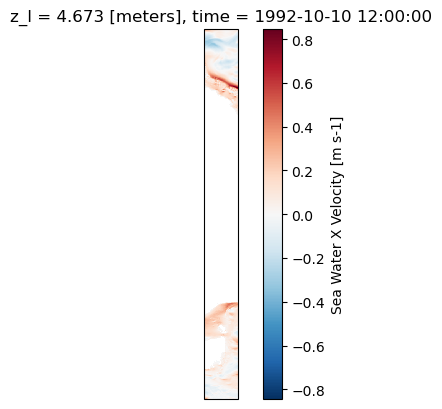

In [64]:
# yh, xq
eac_smokey = eac_2d_snap.sel(xq=slice(smokey_box['W'], smokey_box['E']), yq=slice(smokey_box['S'], smokey_box['N']))
ax=plt.axes(projection=ccrs.PlateCarree())
eac_smokey['uo'].plot(ax=ax, transform=ccrs.PlateCarree())

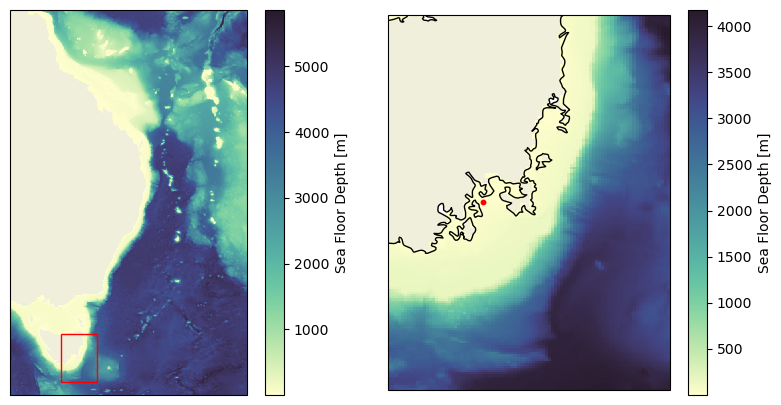

In [65]:
eac_depth = eac_static['deptho']
smokey_depth = eac_depth.sel(xh=slice(smokey_box['W'], smokey_box['E']), yh=slice(smokey_box['S'], smokey_box['N']))

fig, axes = plt.subplots(1,2, figsize=(10,5), subplot_kw = dict(projection=ccrs.PlateCarree()))
eac_depth.plot(ax=axes[0], cmap=cm.cm.deep, transform=ccrs.PlateCarree())
axes[0].add_feature(cfeature.LAND)
box_sc = patches.Rectangle((smokey_box['W'], smokey_box['S']), (smokey_box['E']-smokey_box['W']),
                           (smokey_box['N']-smokey_box['S']), color='r', fill=None, transform=ccrs.PlateCarree())
axes[0].add_patch(box_sc)
smokey_depth.plot(ax=axes[1], cmap=cm.cm.deep, transform=ccrs.PlateCarree())
axes[1].scatter(smokey_cape[0], smokey_cape[1], color='red', marker='o', s=10)
axes[1].add_feature(cfeature.LAND)
axes[1].coastlines()

In [66]:
eac_2d_snap_latlon = eac_2d_snap.rename({'xq':'lon', 'yh':'lat'})
eac_2d_snap_latlon

<xarray.Dataset>
Dimensions:  (lat: 1140, time: 1, lon: 594, xh: 594, yq: 1140)
Coordinates:
  * lat      (lat) float64 -46.18 -46.16 -46.13 -46.11 ... -14.14 -14.11 -14.07
    z_l      float64 4.673
  * time     (time) object 1992-10-10 12:00:00
  * lon      (lon) float64 -217.8 -217.7 -217.7 -217.7 ... -198.1 -198.0 -198.0
  * xh       (xh) float64 -217.8 -217.7 -217.7 -217.7 ... -198.1 -198.0 -198.0
  * yq       (yq) float64 -46.17 -46.14 -46.12 -46.1 ... -14.12 -14.09 -14.06
Data variables:
    uo       (time, lat, lon) float32 -0.02677 -0.005465 ... -0.2489 -0.2552
    vo       (time, lat, lon) float32 nan nan nan nan ... -0.05078 -0.04243 nan
    dxt      (lat, xh) float32 ...
    dyt      (lat, xh) float32 ...
Attributes:
    units:          m s-1
    long_name:      Sea Water X Velocity
    cell_methods:   z_l:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    interp_method:  none

### Using xgcm
Now we're going to regrid to hopefully make things easier for plotting the streamplots

In [67]:
from matplotlib import patches
import cartopy.feature as cfeature
import matplotlib.lines as mlines
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [68]:
def regrid_for_streamplot(u, v, res):
    # Create target grid that has equal spaced points (a requirement for streamplot)
    x_target = np.linspace(u['lon'].min(), u['lon'].max(), int(len(u['lon']) / res))
    y_target = np.linspace(u['lat'].min(), u['lat'].max(), int(len(u['lat']) / res))
    X_target, Y_target = np.meshgrid(x_target, y_target)
    
    # Create regridder object
    regridder = xesmf.Regridder(u, {'lon':X_target, 'lat':Y_target}, 'bilinear')
    
    # regrid data
    u_target = regridder(u)
    v_target = regridder(v)
    
    return x_target, y_target, u_target, v_target

In [69]:
%%time
x, y, u, v = regrid_for_streamplot(u=eac_2d_snap_latlon['uo'], v=eac_2d_snap_latlon['vo'], res=2)

CPU times: user 12.3 s, sys: 843 ms, total: 13.1 s
Wall time: 11.3 s


In [70]:
u = u.squeeze()
v = v.squeeze()

CPU times: user 6.67 s, sys: 145 ms, total: 6.82 s
Wall time: 6.2 s


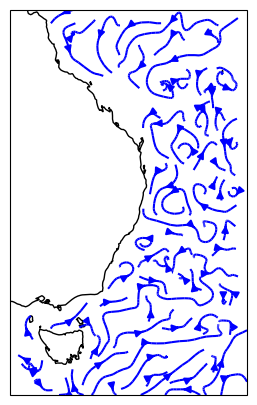

In [124]:
%%time
plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2))
ax.set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())
ax.streamplot(x, y, u, v, density=1, color='b', transform=ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND, color='green')
ax.coastlines()

#### Combine the streamlines with the bathymetry

In [71]:
om2_bath = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v150_iaf_cycle1/output120/ocean/ocean-2d-ht.nc')['ht']
om2_bath_sub = om2_bath.sel(xt_ocean=slice(smokey_box['W'], smokey_box['E']), yt_ocean=slice(smokey_box['S'], smokey_box['N'])).squeeze()
om2_bath_sub

<xarray.DataArray 'ht' (yt_ocean: 54, xt_ocean: 30)>
[1620 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -213.5 -213.4 -213.3 ... -210.8 -210.7 -210.6
  * yt_ocean  (yt_ocean) float64 -45.04 -44.97 -44.89 ... -41.32 -41.24 -41.17
Attributes:
    long_name:      ocean depth on t-cells
    units:          m
    valid_range:    [-1.e+09  1.e+09]
    cell_methods:   time: point
    coordinates:    geolon_t geolat_t
    standard_name:  sea_floor_depth_below_geoid

In [72]:
om2_2d_snap_latlon = om2_2d_snap.rename({'xu_ocean':'lon', 'yu_ocean':'lat'}).sel(lon=slice(smokey_box['W'], smokey_box['E']), lat=slice(smokey_box['S'], smokey_box['N']))
om2_2d_snap_latlon = om2_2d_snap_latlon.chunk({'lon':-1, 'lat':-1})

In [73]:
x_om, y_om, u_om, v_om = regrid_for_streamplot(u=om2_2d_snap_latlon['u'], v=om2_2d_snap_latlon['v'], res=2)
u_om = u_om.squeeze()
v_om = v_om.squeeze()

CPU times: user 844 ms, sys: 86 ms, total: 930 ms
Wall time: 3.33 s


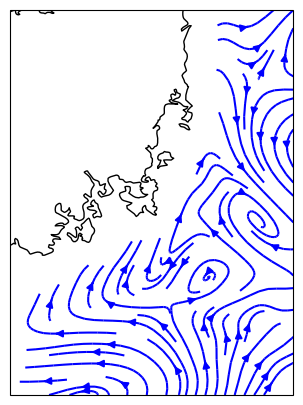

In [39]:
%%time
plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2))
ax.set_extent([x_om.min(), x_om.max(), y_om.min(), y_om.max()], crs=ccrs.PlateCarree())
ax.streamplot(x_om, y_om, u_om, v_om, density=1, color='b', transform=ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND, color='green')
ax.coastlines()

In [37]:
smokey_depth

<xarray.DataArray 'deptho' (yh: 164, xh: 90)>
[14760 values with dtype=float32]
Coordinates:
  * xh       (xh) float64 -213.5 -213.5 -213.5 -213.4 ... -210.6 -210.6 -210.6
  * yh       (yh) float64 -45.08 -45.06 -45.04 -45.01 ... -41.17 -41.14 -41.12
Attributes:
    units:          m
    long_name:      Sea Floor Depth
    cell_methods:   area:mean yh:mean xh:mean time: point
    cell_measures:  area: areacello
    standard_name:  sea_floor_depth_below_geoid

Text(0.5, 0.98, 'SE-TAS Velocity Daily snapshot')

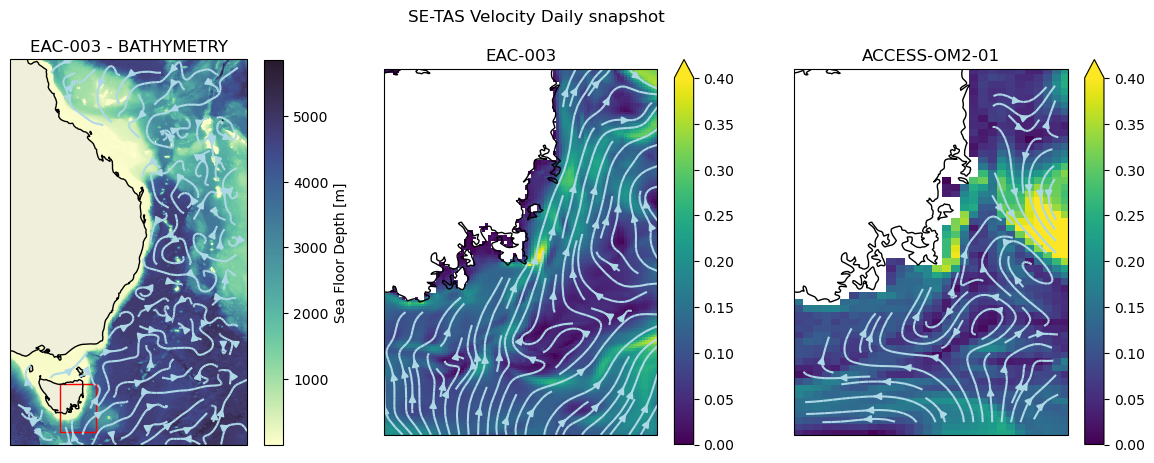

In [79]:
smokey_depth = eac_depth.sel(xh=slice(smokey_box['W'], smokey_box['E']), yh=slice(smokey_box['S'], smokey_box['N']))

fig, axes = plt.subplots(1,3, figsize=(15,5), subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2)))
eac_depth.plot(ax=axes[0], cmap=cm.cm.deep, transform=ccrs.PlateCarree())
axes[0].set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())
axes[0].streamplot(x, y, u, v, density=1, color='lightblue', transform=ccrs.PlateCarree())
axes[0].add_feature(cfeature.LAND)
axes[0].coastlines()
box_sc = patches.Rectangle((smokey_box['W'], smokey_box['S']), (smokey_box['E']-smokey_box['W']),
                           (smokey_box['N']-smokey_box['S']), color='r', fill=None, transform=ccrs.PlateCarree())
axes[0].add_patch(box_sc)
axes[0].set_title('EAC-003 - BATHYMETRY')
eac_speed.plot(ax=axes[1], vmin=0, vmax=.4, transform=ccrs.PlateCarree())
axes[1].set_extent([smokey_depth.xh.min(), smokey_depth.xh.max(), smokey_depth.yh.min(), smokey_depth.yh.max()], crs=ccrs.PlateCarree())
axes[1].streamplot(x, y, u, v, density=1, color='lightblue', transform=ccrs.PlateCarree())
axes[1].scatter(smokey_cape[0], smokey_cape[1], color='grey', marker='o', s=10)
# axes[1].add_feature(cfeature.LAND)
axes[1].coastlines()
axes[1].set_title('EAC-003')

om2_speed.plot(ax=axes[2], vmin=0, vmax=.4, transform=ccrs.PlateCarree())
axes[2].set_extent([smokey_depth.xh.min(), smokey_depth.xh.max(), smokey_depth.yh.min(), smokey_depth.yh.max()], crs=ccrs.PlateCarree())
axes[2].streamplot(x_om, y_om, u_om, v_om, density=1, color='lightblue', transform=ccrs.PlateCarree())
# axes[2].add_feature(cfeature.LAND)
axes[2].coastlines()
axes[2].set_title('ACCESS-OM2-01')

fig.suptitle('SE-TAS Velocity Daily snapshot')

Text(0.5, 0.98, 'SE-TAS Velocity Daily snapshot')

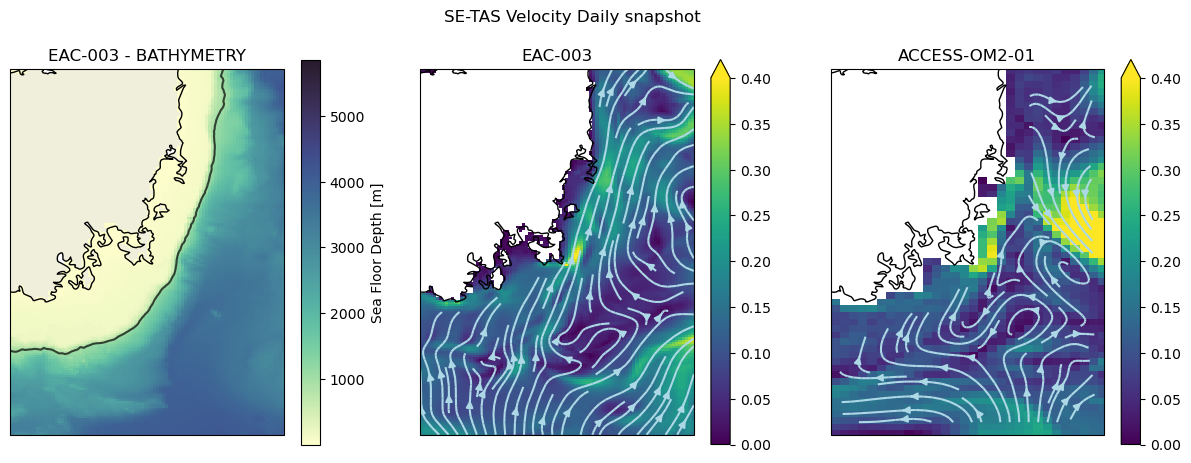

In [88]:
smokey_depth = eac_depth.sel(xh=slice(smokey_box['W'], smokey_box['E']), yh=slice(smokey_box['S'], smokey_box['N']))

fig, axes = plt.subplots(1,3, figsize=(15,5), subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2)))
eac_depth.plot(ax=axes[0], cmap=cm.cm.deep, transform=ccrs.PlateCarree())
# axes[0].set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())
axes[0].set_extent([smokey_depth.xh.min(), smokey_depth.xh.max(), smokey_depth.yh.min(), smokey_depth.yh.max()], crs=ccrs.PlateCarree())
c1 = eac_depth.plot.contour(ax=axes[0], levels=[1000], colors='k', transform=ccrs.PlateCarree(), alpha=0.7)
axes[0].clabel(c1, inline=1, fontsize=5)
# axes[0].streamplot(x, y, u, v, density=1, color='lightblue', transform=ccrs.PlateCarree())
axes[0].add_feature(cfeature.LAND)
axes[0].coastlines()
box_sc = patches.Rectangle((smokey_box['W'], smokey_box['S']), (smokey_box['E']-smokey_box['W']),
                           (smokey_box['N']-smokey_box['S']), color='r', fill=None, transform=ccrs.PlateCarree())
axes[0].add_patch(box_sc)
axes[0].set_title('EAC-003 - BATHYMETRY')
eac_speed.plot(ax=axes[1], vmin=0, vmax=.4, transform=ccrs.PlateCarree())
axes[1].set_extent([smokey_depth.xh.min(), smokey_depth.xh.max(), smokey_depth.yh.min(), smokey_depth.yh.max()], crs=ccrs.PlateCarree())
axes[1].streamplot(x, y, u, v, density=1, color='lightblue', transform=ccrs.PlateCarree())
axes[1].scatter(smokey_cape[0], smokey_cape[1], color='grey', marker='o', s=10)
# axes[1].add_feature(cfeature.LAND)
axes[1].coastlines()
axes[1].set_title('EAC-003')

om2_speed.plot(ax=axes[2], vmin=0, vmax=.4, transform=ccrs.PlateCarree())
axes[2].set_extent([smokey_depth.xh.min(), smokey_depth.xh.max(), smokey_depth.yh.min(), smokey_depth.yh.max()], crs=ccrs.PlateCarree())
axes[2].streamplot(x_om, y_om, u_om, v_om, density=1, color='lightblue', transform=ccrs.PlateCarree())
# axes[2].add_feature(cfeature.LAND)
axes[2].coastlines()
axes[2].set_title('ACCESS-OM2-01')

fig.suptitle('SE-TAS Velocity Daily snapshot')

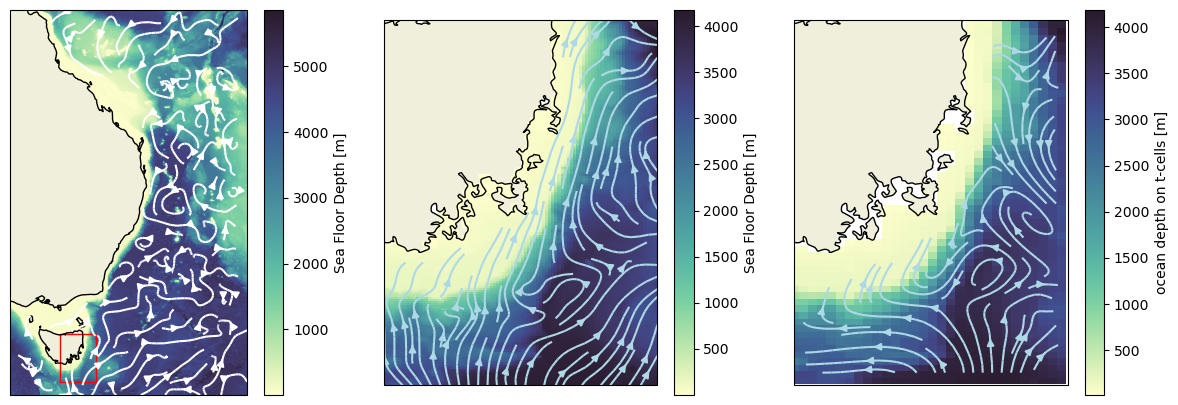

In [38]:
smokey_depth = eac_depth.sel(xh=slice(smokey_box['W'], smokey_box['E']), yh=slice(smokey_box['S'], smokey_box['N']))

fig, axes = plt.subplots(1,3, figsize=(15,5), subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=(x.min()+x.max())/2)))
eac_depth.plot(ax=axes[0], cmap=cm.cm.deep, transform=ccrs.PlateCarree())
axes[0].set_extent([x.min(), x.max(), y.min(), y.max()], crs=ccrs.PlateCarree())
axes[0].streamplot(x, y, u, v, density=1, color='w', transform=ccrs.PlateCarree())
axes[0].add_feature(cfeature.LAND)
axes[0].coastlines()
box_sc = patches.Rectangle((smokey_box['W'], smokey_box['S']), (smokey_box['E']-smokey_box['W']),
                           (smokey_box['N']-smokey_box['S']), color='r', fill=None, transform=ccrs.PlateCarree())
axes[0].add_patch(box_sc)
smokey_depth.plot(ax=axes[1], cmap=cm.cm.deep, transform=ccrs.PlateCarree())
axes[1].set_extent([smokey_depth.xh.min(), smokey_depth.xh.max(), smokey_depth.yh.min(), smokey_depth.yh.max()], crs=ccrs.PlateCarree())
axes[1].streamplot(x, y, u, v, density=1, color='lightblue', transform=ccrs.PlateCarree())
axes[1].scatter(smokey_cape[0], smokey_cape[1], color='grey', marker='o', s=10)
axes[1].add_feature(cfeature.LAND)
axes[1].coastlines()

om2_bath_sub.plot(ax=axes[2], cmap=cm.cm.deep, transform=ccrs.PlateCarree())
axes[2].set_extent([smokey_depth.xh.min(), smokey_depth.xh.max(), smokey_depth.yh.min(), smokey_depth.yh.max()], crs=ccrs.PlateCarree())
axes[2].streamplot(x_om, y_om, u_om, v_om, density=1, color='lightblue', transform=ccrs.PlateCarree())
axes[2].add_feature(cfeature.LAND)
axes[2].coastlines()

